# Load Dataset with Kaggle API

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import zipfile
import os
from kaggle.api.kaggle_api_extended import KaggleApi
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Initialize the Kaggle API
api = KaggleApi()
api.authenticate()

In [3]:
# Download the dataset
dataset = 'kanchana1990/e-commerce-furniture-dataset-2024'
api.dataset_download_files(dataset, path='e-commerce-furniture-dataset-2024', unzip=False)

In [4]:
# Unzip the dataset
with zipfile.ZipFile("e-commerce-furniture-dataset-2024/e-commerce-furniture-dataset-2024.zip",'r') as file:
    file.extractall("e-commerce-furniture-dataset-2024")

In [5]:
# List the files in the unzipped directory to find the correct csv file name
print(os.listdir("e-commerce-furniture-dataset-2024"))

['e-commerce-furniture-dataset-2024.zip', 'ecommerce_furniture_dataset_2024.csv']


In [6]:
# Load the data
df = pd.read_csv("e-commerce-furniture-dataset-2024/ecommerce_furniture_dataset_2024.csv")
df

,productTitle,originalPrice,price,sold,tagText
0,Dresser For Bedroom With 9 Fabric Drawers Ward...,NaN,$46.79,600,Free shipping
1,Outdoor Conversation Set 4 Pieces Patio Furnit...,NaN,$169.72,0,Free shipping
2,Desser For Bedroom With 7 Fabric Drawers Organ...,$78.4,$39.46,7,Free shipping
3,"Modern Accent Boucle Chair,Upholstered Tufted ...",NaN,$111.99,0,Free shipping
4,Small Unit Simple Computer Desk Household Wood...,$48.82,$21.37,1,Free shipping
...,...,...,...,...,...
1995,Modern TV Stand Entertainment Center with Two ...,NaN,$72.49,8,Free shipping
1996,"Large Wardrobe Armoire Closet with 3 Doors, Fr...",NaN,$276.65,2,Free shipping
1997,"Velvet Futon Sofa Bed, 73-inch Sleeper Couch w...",NaN,$196.44,10,Free shipping
1998,Furniture Acrylic Coffee Table Transparent Liv...,NaN,$228.18,0,Free shipping


# Data Cleaning

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   productTitle   2000 non-null   object
 1   originalPrice  487 non-null    object
 2   price          2000 non-null   object
 3   sold           2000 non-null   int64 
 4   tagText        1997 non-null   object
dtypes: int64(1), object(4)
memory usage: 78.3+ KB


In [10]:
df.shape

(2000, 5)

In [11]:
# Check for duplicates
df.duplicated().sum()

94

In [12]:
# Remove duplicates
df.drop_duplicates(inplace=True)

In [13]:
# Re-checking for duplicates
df.duplicated().sum()

0

In [15]:
# Checking for missing values
df.isnull().sum()

productTitle        0
originalPrice    1436
price               0
sold                0
tagText             2
dtype: int64

In [25]:
# Filled na values in originalPrice column with values in price column as no discounts were applied
df['originalPrice'].fillna(df['price'], inplace=True)
df['tagText'].fillna('Free shipping', inplace=True)

# Verify changes
df.isnull().sum()

productTitle     0
originalPrice    0
price            0
sold             0
tagText          0
dtype: int64

In [29]:
# Rename columns
df.rename({'productTitle':'product title', 'originalPrice':'original price','sold':'quantity sold','tagText':'cost of shipping'},axis=1,inplace=True)

In [34]:
# Remove dollar sign from price column
df['price'] = df['price'].str.replace('$','',).str.replace(',','')
# Change price column from string to float
df['price'] = df['price'].astype('float')

In [38]:
# Remove dollar sign from original price column
df['original price'] = df['original price'].str.replace('$','',).str.replace(',','')
# Change original price data type from string to float
df['original price'] = df['original price'].astype('float')

In [56]:
# Remove'+Shipping: $' from the cost of shipping column and convert 'Free shipping' to 0
df['cost of shipping'] = df['cost of shipping'].str.replace('Free shipping', '0')
df['cost of shipping'] = df['cost of shipping'].str.replace('+Shipping: $', '')
df['cost of shipping'] = df['cost of shipping'].str.replace(',', '')

# Convert cost of shipping column from string to float
df['cost of shipping'] = df['cost of shipping'].astype('float')

In [44]:
# Create new column for revenue
df['total revenue'] = df['price'] * df['quantity sold']

# Create new column for discount
df['discount'] = df['original price'] - df['price']

# Create new column for discount percentage
df['discount percentage'] = (df['discount'] / df['original price']) * 100

In [49]:
# Calculate gross profit and margin
df['gross profit'] = df['total revenue'] - (df['original price'] * df['quantity sold'])
df['gross profit margin'] = np.where(df['total revenue'] !=0, (df['gross profit'] / df['total revenue']) * 100, 0)

In [62]:
# Calculate net profit
df['net profit'] = df['total revenue'] - (df['original price'] * df['quantity sold']) - (df['cost of shipping'] * df['quantity sold'])
# Calculate net profit margin
df['net profit margin'] = np.where(df['total revenue'] !=0, (df['net profit'] / df['total revenue']) * 100, 0)

In [64]:
# Function to extract product type from the title
def extract_product_type(title):
    keywords = ['Chair', 'Table', 'Dresser', 'Sofa', 'Bed', 'Dining Set']
    for keyword in keywords:
        if keyword.lower() in title.lower():
            return keyword
    return 'Other'

# Function to extract brand from the title
def extract_brand(title):
    brand_patterns = ['Christopher Knight Home', 'Project 62', 'Eco Dream', 'Room & Joy', 'Captiva Designs']
    for brand in brand_patterns:
        if brand.lower() in title.lower():
            return brand
    return 'Unknown'

In [66]:
# Apply the functions to create new columns
df['productType'] = df['product title'].apply(extract_product_type)
df['brand'] = df['product title'].apply(extract_brand)

In [74]:
# Creating bins for original price
original_price_bins = [0, 100, 500, 1000, float('inf')]
original_price_labels = ['Low', 'Medium', 'High', 'Very High']
df['original price bin'] = pd.cut(df['original price'], bins=original_price_bins, labels=original_price_labels, right=False)

In [71]:
# Creating bins for price
price_bins = [0, 100, 500, 1000, float('inf')]
price_labels = ['Low', 'Medium', 'High', 'Very High']
df['price bin'] = pd.cut(df['price'], bins=price_bins, labels=price_labels, right=False)

In [84]:
# Creating bins for discount percentage
discount_bins = [-float('inf'), 0, 10, 25, 50, float('inf')]
discount_labels = ['No Discount', 'Low Discount', 'Medium Discount', 'High Discount', 'Very High Discount']
df['discount percentage bin'] = pd.cut(df['discount percentage'], bins=discount_bins, labels=discount_labels, right=False)

In [86]:
# Creating bins for cost of shipping
shipping_cost_bins = [0, 5, 15, float('inf')]
shipping_cost_labels = ['Low', 'Medium', 'High']
df['shipping cost bin'] = pd.cut(df['cost of shipping'], bins=shipping_cost_bins, labels=shipping_cost_labels, right=False).cat.add_categories(['Free'])
df['shipping cost bin'].fillna('Free', inplace=True)

In [88]:
# Creating sales category based on quantity sold
df['sales category'] = pd.cut(df['quantity sold'], bins=[-1,0,10, float('inf')], labels=['No Sales', 'Low Sales', 'High Sales'])

In [90]:
# Creating column for revenue per unit
df['revenue per unit'] = df['total revenue'] / df['quantity sold']
# Handling rows that divide by zero
df['revenue per unit'].fillna(0, inplace=True)

In [92]:
# Creating a column to see the cost per unit
df['cost per unit'] = (df['original price'] + df['cost of shipping'] / df['quantity sold'])
# Handling rows that are divided by zero
df['cost per unit'].fillna(0, inplace=True)

In [94]:
# Creating a column for profit category based on profit margins
df['profit category'] = pd.cut(df['net profit margin'], bins=[-float('inf'), 0, 20, 50, float('inf')], labels=['Loss', 'Low Profit', 'Medium Profit', 'High Profit'])

# Visualizations

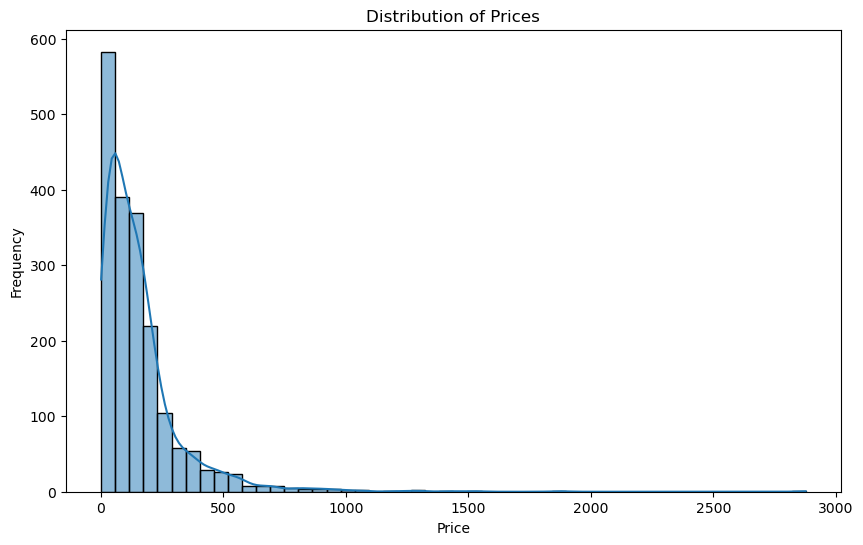

In [96]:
# Price Distribution of prices and quantities sold
plt.figure(figsize=(10,6))
sns.histplot(df['price'], bins=50, kde=True)
plt.title('Distribution of Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

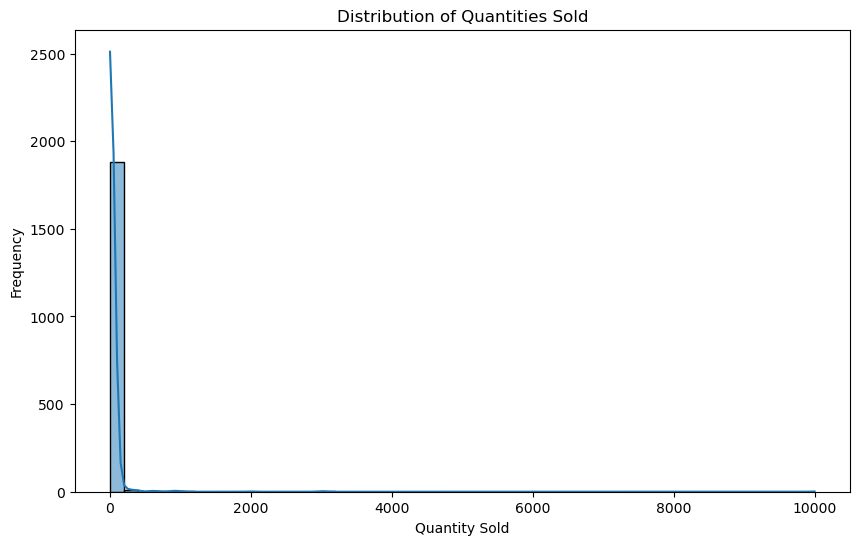

In [97]:
# Quantities Sold
plt.figure(figsize=(10,6))
sns.histplot(df['quantity sold'], bins=50, kde=True)
plt.title('Distribution of Quantities Sold')
plt.xlabel('Quantity Sold')
plt.ylabel('Frequency')
plt.show()

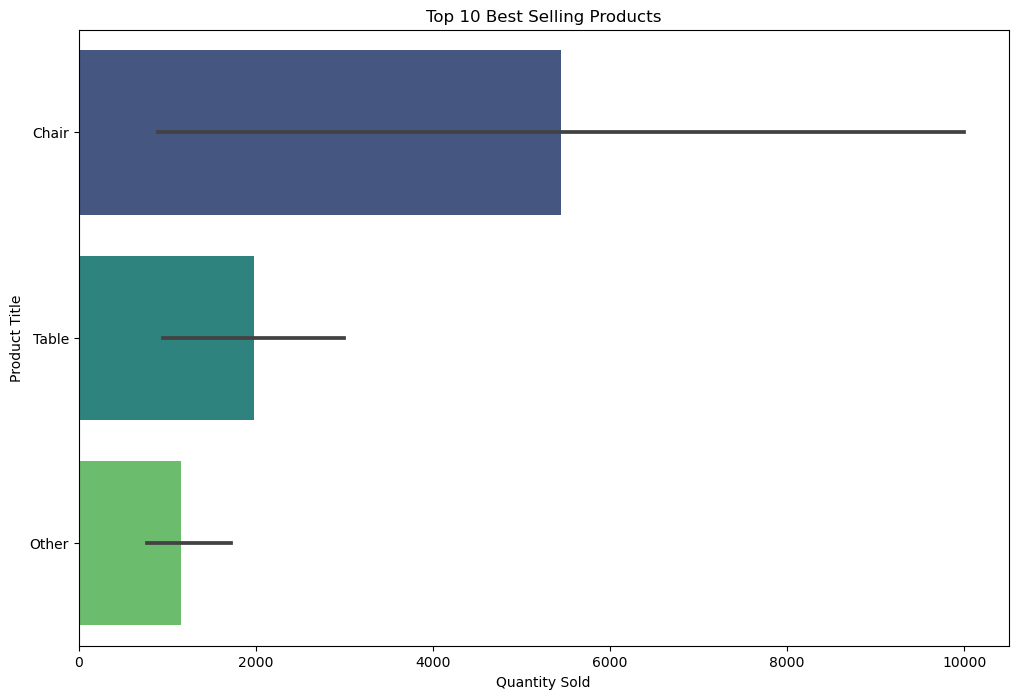

In [109]:
# Top 10 Best Selling Products and their contribution to total revenue
top_sold = df.sort_values(by='quantity sold', ascending=False).head(10)

plt.figure(figsize=(12, 8))
sns.barplot(x='quantity sold', y='productType', data=top_sold, palette='viridis')
plt.title('Top 10 Best Selling Products')
plt.xlabel('Quantity Sold')
plt.ylabel('Product Title')
plt.show()

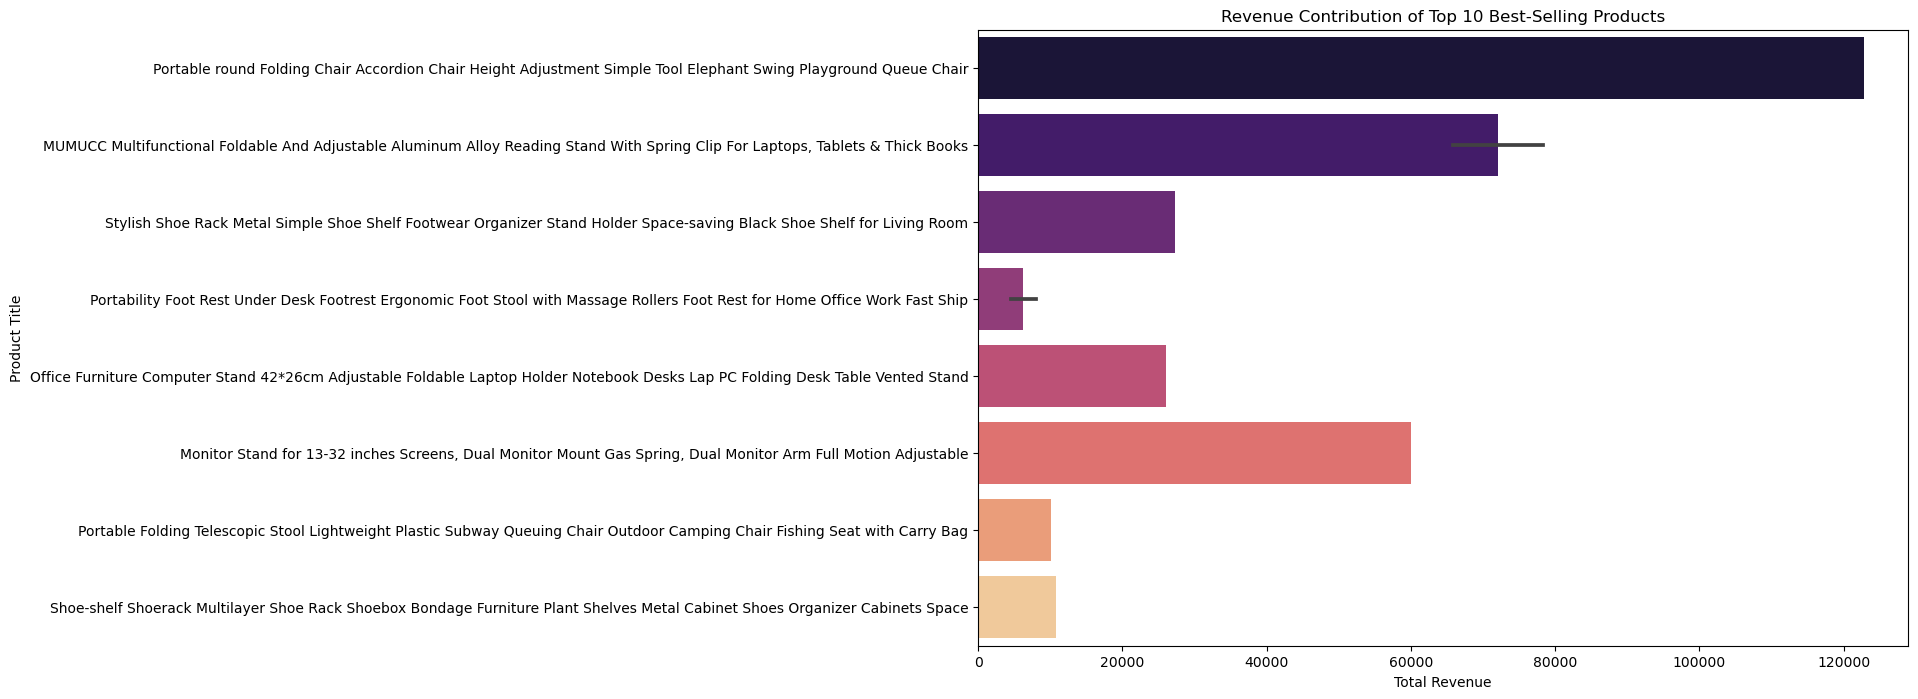

In [125]:
# Revenue contributino of Top 10 Best Selling Products
plt.figure(figsize=(12, 8))
sns.barplot(x='total revenue', y='product title', data=top_sold, palette='magma')
plt.title('Revenue Contribution of Top 10 Best-Selling Products')
plt.xlabel('Total Revenue')
plt.ylabel('Product Title')
plt.show()

In [123]:
# Aggregating similar products under common categories
df['product category'] = df['product title'].apply(lambda x: ' '.join(x.split()[:2]))

# Creating a new column combining brand and productType
df['brand product'] = df['brand'] + ' ' + df['productType']

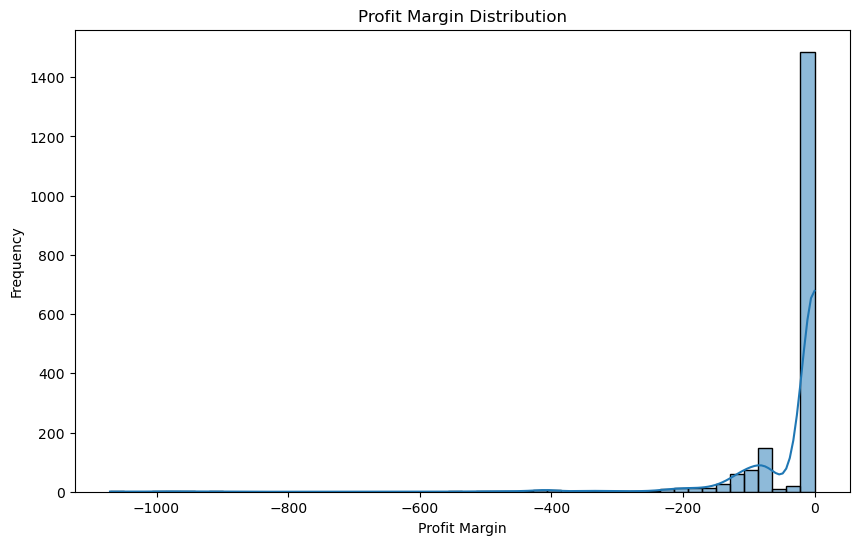

In [127]:
# Profit Margin Distribution
plt.figure(figsize=(10,6))
sns.histplot(df['gross profit margin'], bins=50, kde=True)
plt.title('Profit Margin Distribution')
plt.xlabel('Profit Margin')
plt.ylabel('Frequency')
plt.show()

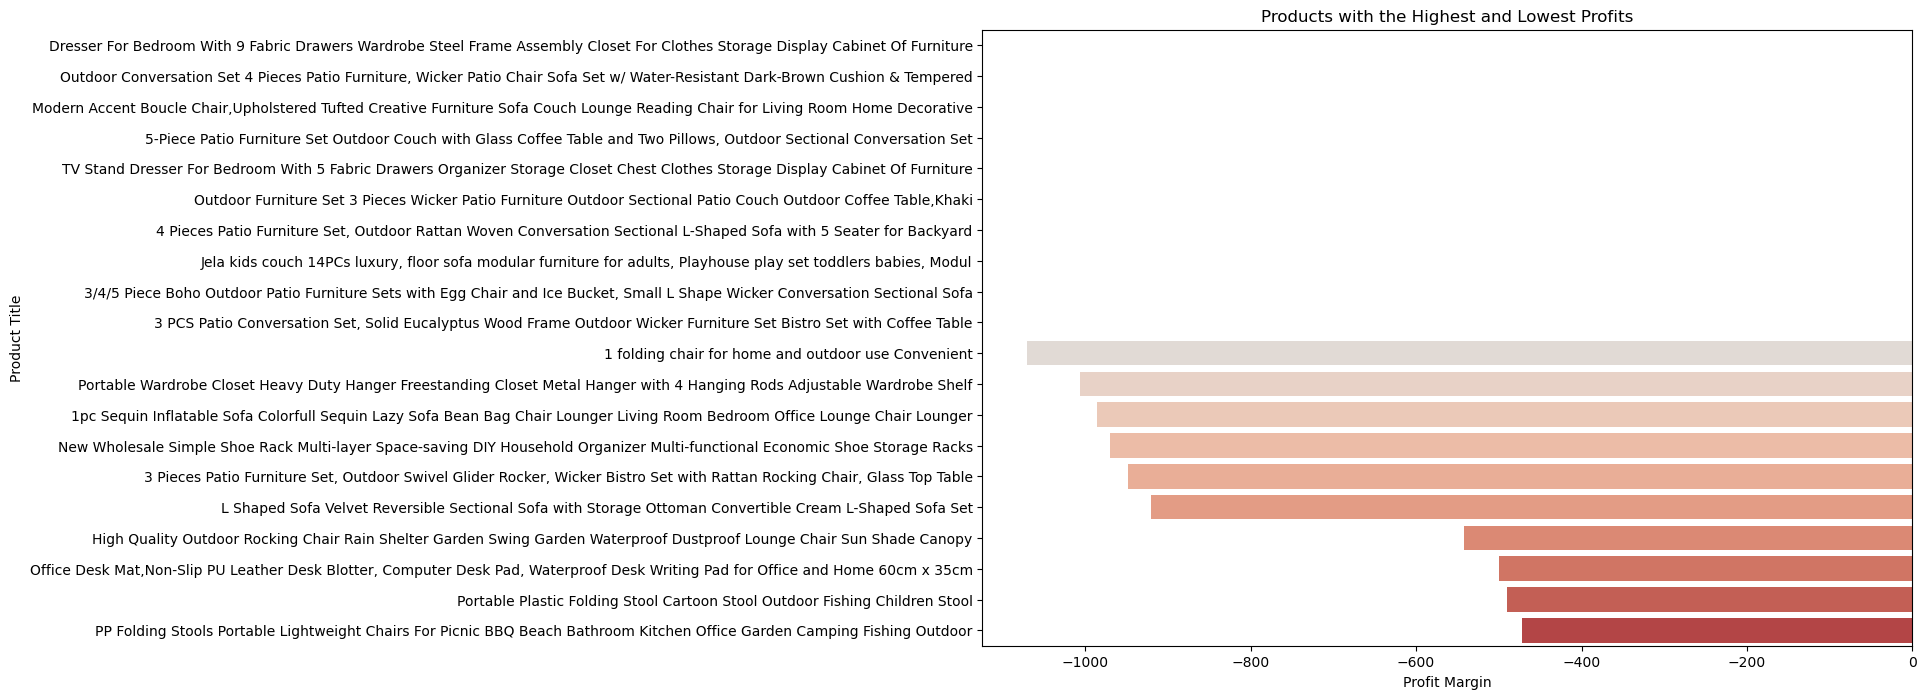

In [131]:
# Products with the Highest and Lowest Profits
highest_profits = df.nlargest(10, 'gross profit margin')
lowest_profits = df.nsmallest(10, 'gross profit margin')

plt.figure(figsize=(12, 8))
sns.barplot(x='gross profit margin', y='product title', data=pd.concat([highest_profits, lowest_profits]), palette='coolwarm')
plt.title('Products with the Highest and Lowest Profits')
plt.xlabel('Profit Margin')
plt.ylabel('Product Title')
plt.show()

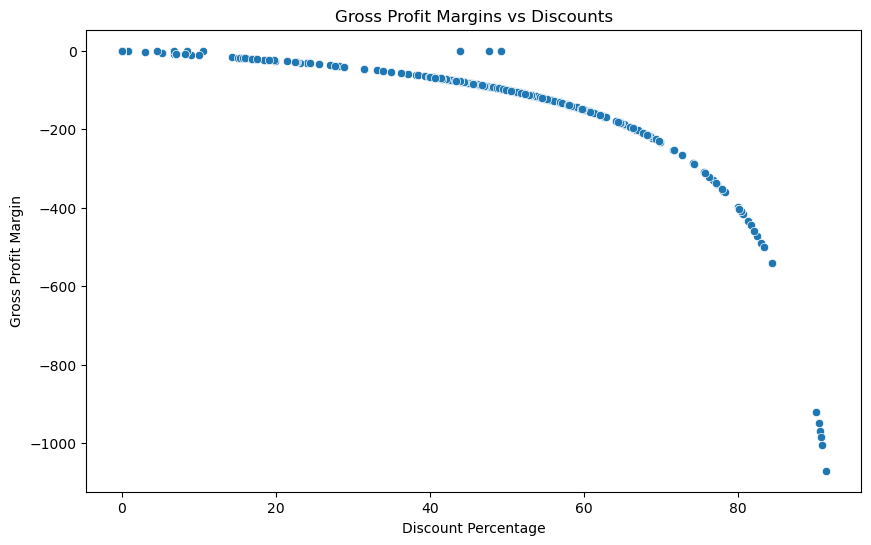

In [132]:
# Impact of Discounts and Costs on Profit Margins
plt.figure(figsize=(10,6))
sns.scatterplot(x='discount percentage', y='gross profit margin', data=df)
plt.title('Gross Profit Margins vs Discounts')
plt.xlabel('Discount Percentage')
plt.ylabel('Gross Profit Margin')
plt.show()

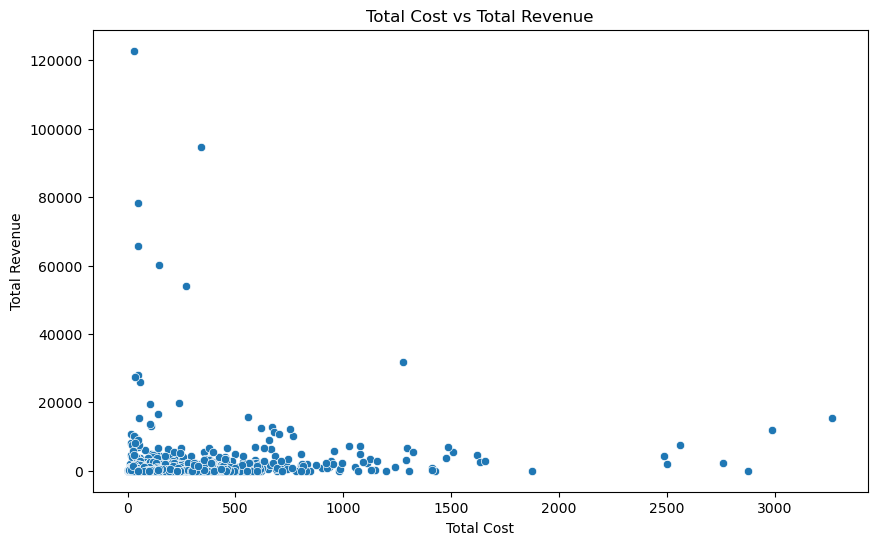

In [134]:
# Total Cost vs Total Revenue
plt.figure(figsize=(10,6))
sns.scatterplot(x=df['original price'] + df['cost of shipping'], y='total revenue', data=df)
plt.title('Total Cost vs Total Revenue')
plt.xlabel('Total Cost')
plt.ylabel('Total Revenue')
plt.show()

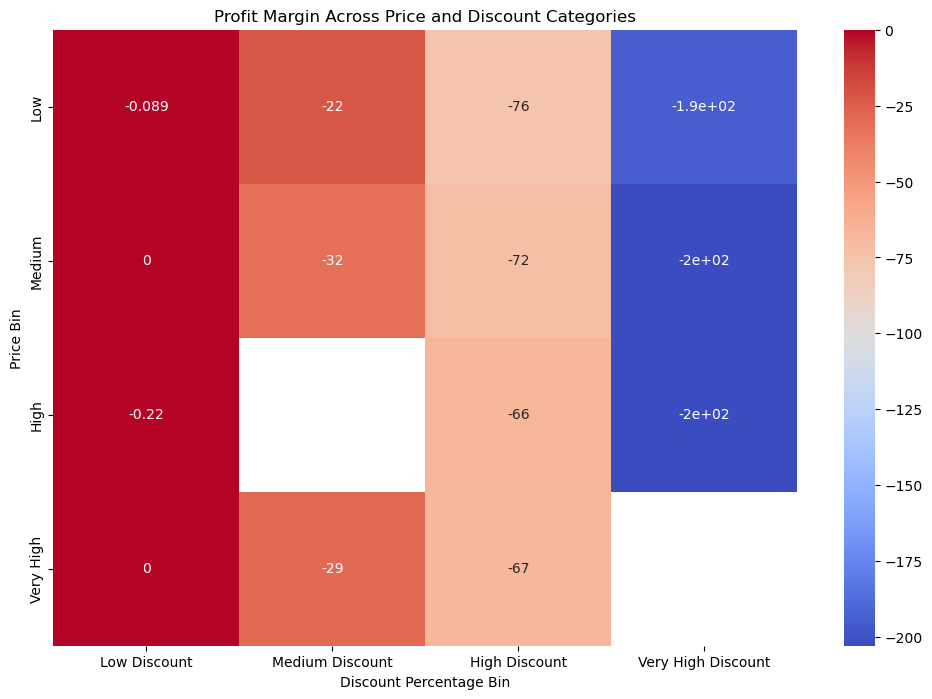

In [137]:
# Performance Metrics Across Bins and Categories
plt.figure(figsize=(12, 8))
sns.heatmap(df.pivot_table(index='price bin', columns='discount percentage bin', values='gross profit margin', aggfunc='mean'), annot=True, cmap='coolwarm')
plt.title('Profit Margin Across Price and Discount Categories')
plt.xlabel('Discount Percentage Bin')
plt.ylabel('Price Bin')
plt.show()

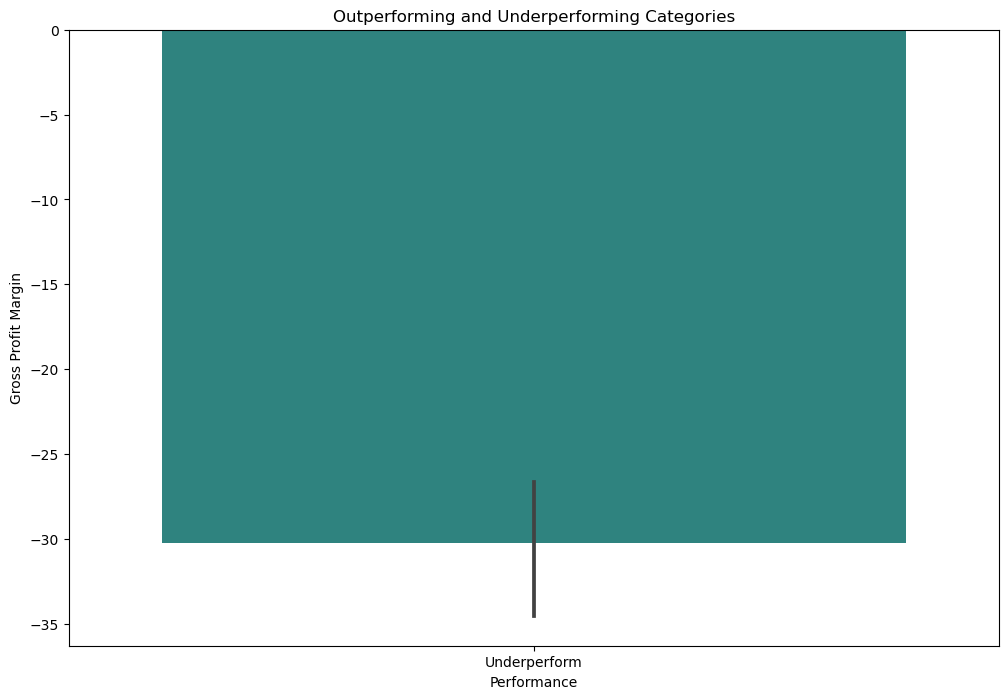

In [138]:
# Outperforming and Underperforming Categories
df['performance'] = np.where(df['gross profit margin'] > df['gross profit margin'].quantile(0.75), 'Outperform', 'Underperform')

plt.figure(figsize=(12, 8))
sns.barplot(x='performance', y='gross profit margin', data=df, palette='viridis')
plt.title('Outperforming and Underperforming Categories')
plt.xlabel('Performance')
plt.ylabel('Gross Profit Margin')
plt.show()


In [140]:
df

,product title,original price,price,quantity sold,cost of shipping,total revenue,discount,discount percentage,gross profit,gross profit margin,...,original price bin,discount percentage bin,shipping cost bin,sales category,revenue per unit,cost per unit,profit category,product category,brand product,performance
0,Dresser For Bedroom With 9 Fabric Drawers Ward...,46.79,46.79,600,0.0,28074.00,0.00,0.000000,0.00,0.00000,...,Low,Low Discount,Low,High Sales,46.79,46.79,Loss,Dresser For,Unknown Dresser,Underperform
1,Outdoor Conversation Set 4 Pieces Patio Furnit...,169.72,169.72,0,0.0,0.00,0.00,0.000000,0.00,0.00000,...,Medium,Low Discount,Low,No Sales,0.00,0.00,Loss,Outdoor Conversation,Unknown Chair,Underperform
2,Desser For Bedroom With 7 Fabric Drawers Organ...,78.40,39.46,7,0.0,276.22,38.94,49.668367,-272.58,-98.68221,...,Low,High Discount,Low,Low Sales,39.46,78.40,Loss,Desser For,Unknown Bed,Underperform
3,"Modern Accent Boucle Chair,Upholstered Tufted ...",111.99,111.99,0,0.0,0.00,0.00,0.000000,0.00,0.00000,...,Medium,Low Discount,Low,No Sales,0.00,0.00,Loss,Modern Accent,Unknown Chair,Underperform
4,Small Unit Simple Computer Desk Household Wood...,48.82,21.37,1,0.0,21.37,27.45,56.226956,-27.45,-128.45110,...,Low,Very High Discount,Low,Low Sales,21.37,48.82,Loss,Small Unit,Unknown Table,Underperform
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1992,Oversized Outdoor Swivel Rocker Chairs Set wit...,555.46,555.46,0,0.0,0.00,0.00,0.000000,0.00,0.00000,...,High,Low Discount,Low,No Sales,0.00,0.00,Loss,Oversized Outdoor,Unknown Chair,Underperform
1993,6pcs Patio Furniture Set PE Rattan Wicker Sect...,325.83,325.83,4,0.0,1303.32,0.00,0.000000,0.00,0.00000,...,Medium,Low Discount,Low,Low Sales,325.83,325.83,Loss,6pcs Patio,Unknown Table,Underperform
1994,Garden Furniture 4507 (Dark Grey) Steel Frame ...,105.16,105.16,2,0.0,210.32,0.00,0.000000,0.00,0.00000,...,Medium,Low Discount,Low,Low Sales,105.16,105.16,Loss,Garden Furniture,Unknown Chair,Underperform
1998,Furniture Acrylic Coffee Table Transparent Liv...,228.18,228.18,0,0.0,0.00,0.00,0.000000,0.00,0.00000,...,Medium,Low Discount,Low,No Sales,0.00,0.00,Loss,Furniture Acrylic,Unknown Table,Underperform
